# ZINFANDEL

In [11]:
%matplotlib inline
import riesling
os=1.3
recon_settings=f'--kernel=KB3 --os={os} --iter_fov=256'
sl_read=slice(0,16)
sl_spk=slice(0,1024)

First create the phantom. We do this three ways:
1 - With no gap as a reference
2 - With samples in the dead-time gap blanked (set to zero) which is appropriate for the projection GRAPPA and SLR methods
3 - With samples in the dead-time gap removed from the non-cartesian k-space which is appropriate for cgSENSE (as those samples should not be sampled during the iterative recon)

In [12]:
phantom_settings='--fov=128 --matrix=64 --phan_rad=48 --shepp_logan --channels=8 --os=2.5'
gap=3
blanked=f'blank{gap}'
trimmed=f'trim{gap}'
!riesling phantom gap0 {phantom_settings}
!riesling phantom {blanked} {phantom_settings} --blank={gap}
!riesling phantom {trimmed} {phantom_settings} --trim={gap}

Reconstruct all to demonstrate dead-time gap artefacts and non-equivalence of blanking/trimming

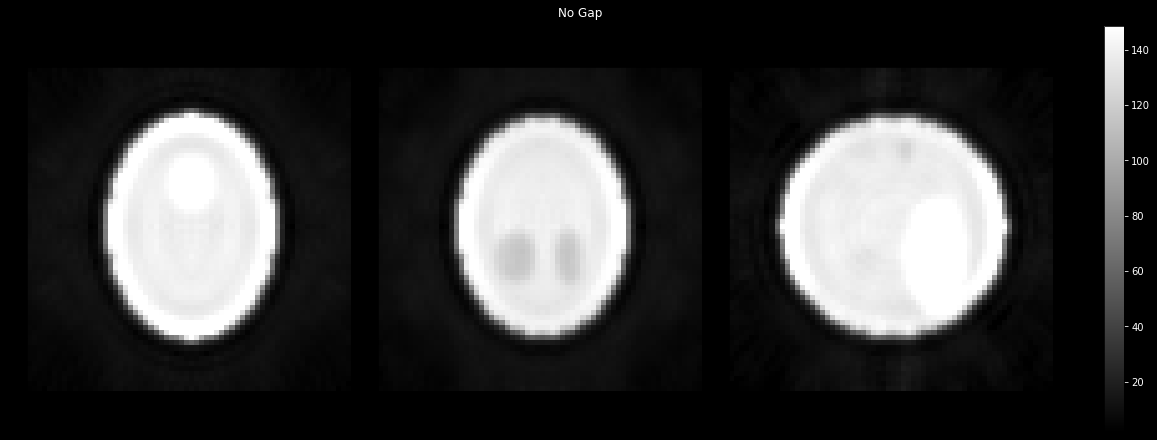

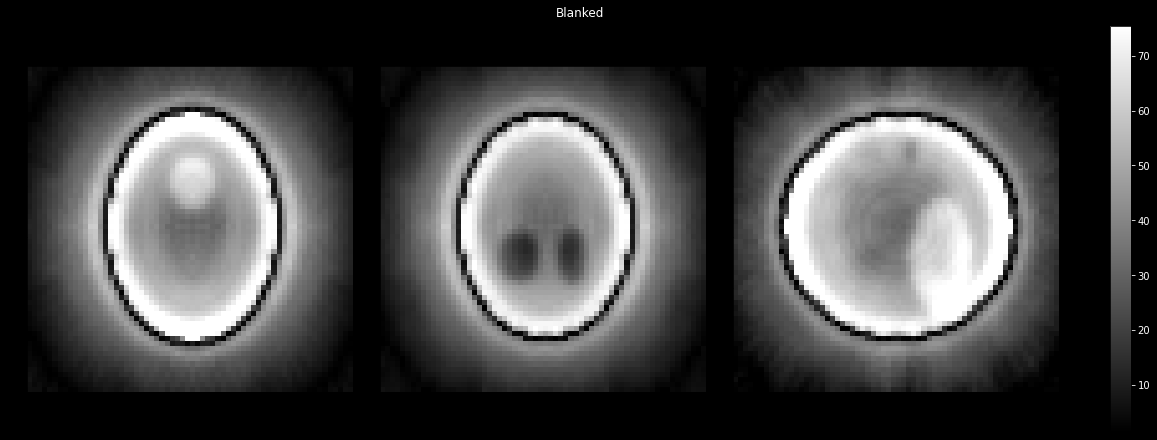

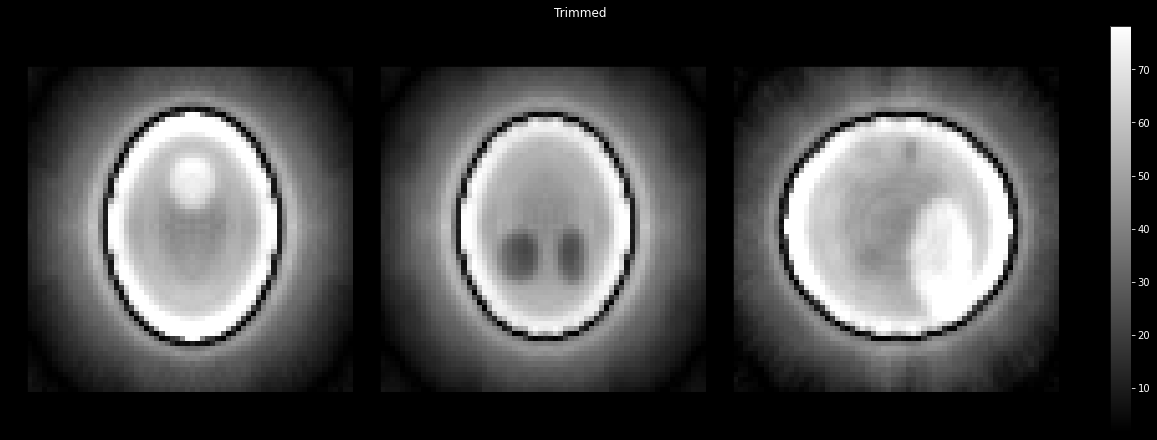

In [19]:
!riesling cg gap0.h5 {recon_settings}
!riesling cg {blanked}.h5 {recon_settings}
!riesling cg {trimmed}.h5 {recon_settings}
display(riesling.images.single('gap0-cg.h5', title='No Gap'))
display(riesling.images.single(f'{blanked}-cg.h5', title='Blanked'))
display(riesling.images.single(f'{trimmed}-cg.h5', title='Trimmed'))

First, try filling the dead-time gap with a projection GRAPPA type method. This is implemented in the basic `zinfandel` command.

Starting: zinfandel
Opened file blank3.h5 for reading
Read dataset: trajectory
Read dataset: echoes
Created trajectory object with 4096 spokes
Opened file blank3-zinfandel.h5 for writing data
Created trajectory object with 4096 spokes
Writing info struct
Wrote dataset: trajectory
Wrote dataset: echoes
Writing meta data
Reading non-cartesian volume 0
ZINFANDEL Gap 3 Sources 4 Cal Spokes/Read 5/57 
Wrote dataset: noncartesian
Finished


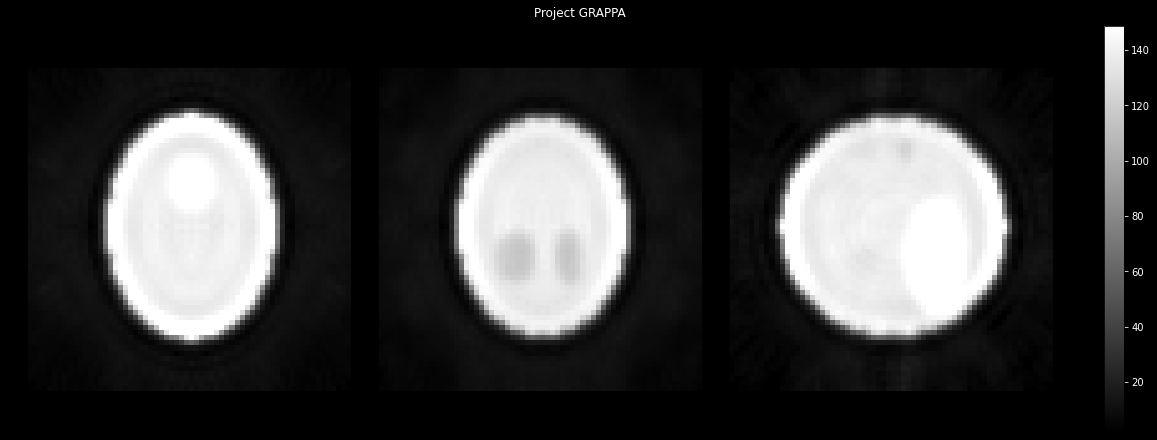

In [14]:
!riesling zinfandel {blanked}.h5 --gap=3 -v
!riesling cg {blanked}-zinfandel.h5 {recon_settings}
display(riesling.images.single(f'{blanked}-zinfandel-cg.h5', title='Project GRAPPA'))

Let's compare some k-spaces

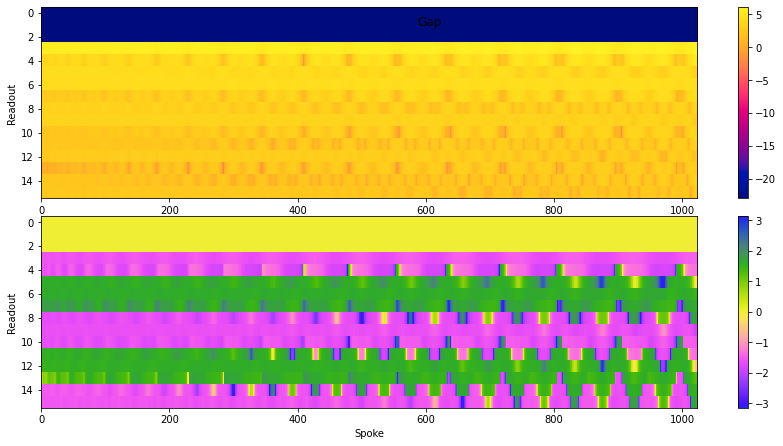

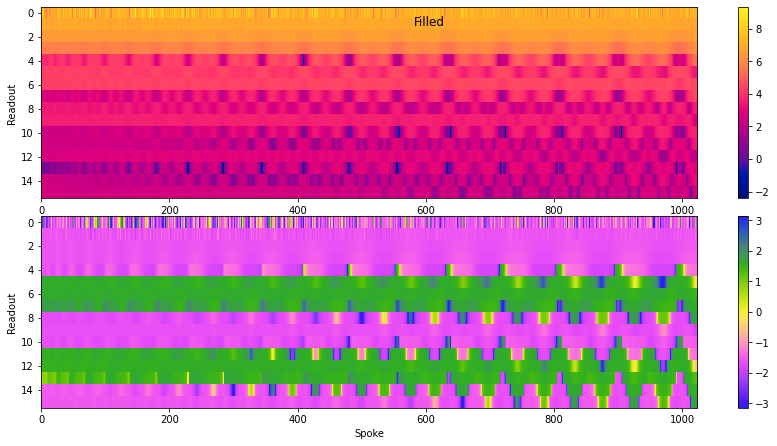

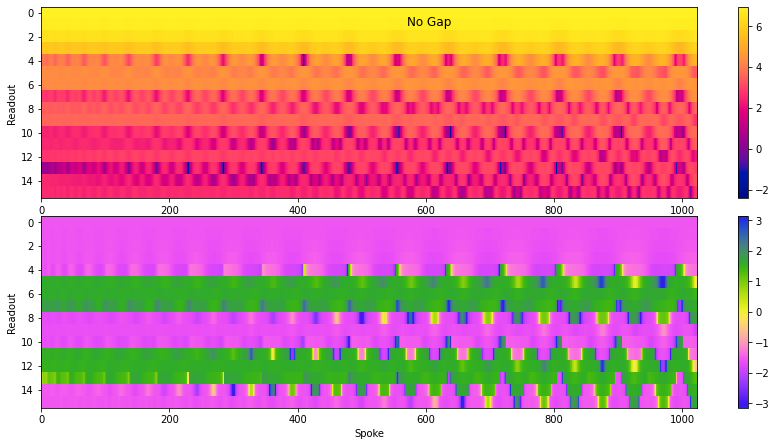

In [15]:
display(riesling.plots.kspace(f'{blanked}.h5', title='Gap', sl_read=sl_read, sl_spoke=sl_spk))
display(riesling.plots.kspace(f'{blanked}-zinfandel.h5', title='Filled', sl_read=sl_read, sl_spoke=sl_spk))
display(riesling.plots.kspace('gap0.h5', title='No Gap', sl_read=sl_read, sl_spoke=sl_spk))

Now let's try by calculating some SENSE maps and then doing an iterative recon, then work back to k-space.

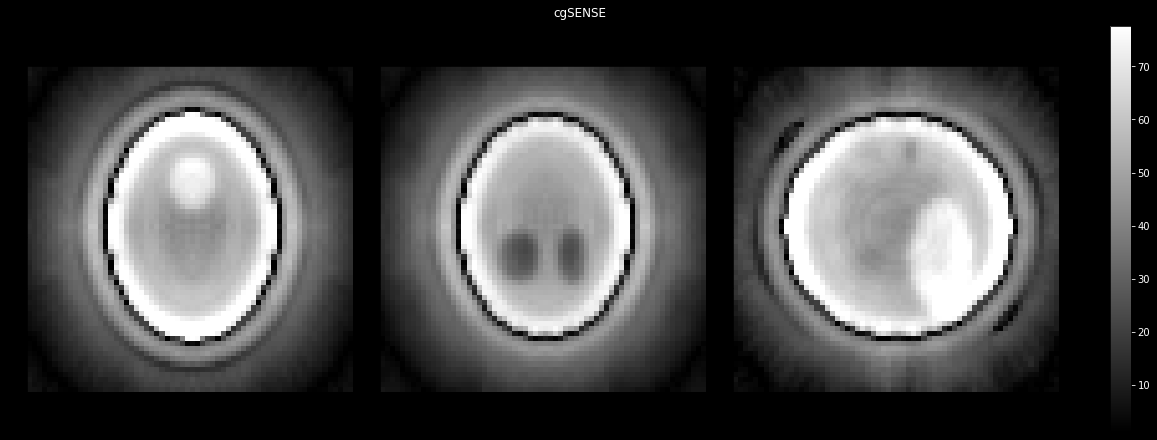

In [30]:
# !riesling sense-calib gap0.h5 --fov=256
!riesling cg {trimmed}.h5 --sense=gap0-sense.h5 {recon_settings}
display(riesling.images.single(f'{trimmed}-cg.h5', title='cgSENSE'))

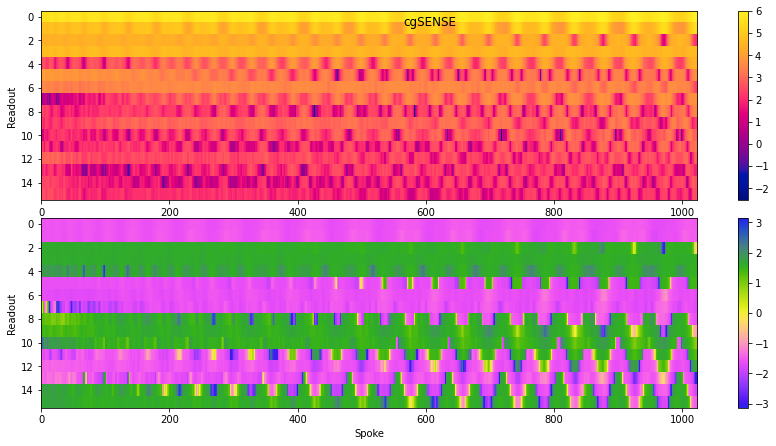

In [35]:
!riesling pad {trimmed}-cg.h5 128,128,128
!riesling sense {trimmed}-cg-pad.h5 gap0-sense.h5
!riesling nufft {trimmed}-cg-pad-sense.h5 --kernel=KB3 --os={os}
display(riesling.plots.kspace(f'{trimmed}-cg-pad-sense-nufft.h5', title='cgSENSE', sl_read=sl_read, sl_spoke=sl_spk))